# **Vizualizing the Branch-and-Bound tree of a problem after (partially) solving it**

***callback_newnode.ipynb***

This example shows how to visualize the Branch-and-Bound (B&B) tree of a problem after (partially) solving it. It assumes that all variables to be branched on in the problem are binary variables.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress

In this example, we read a problem from an external file and define **a callback function to save information of each node of the B&B tree during an optimization run**, which stops after a pre-defined number of nodes have been explored. The tree is plotted after the solve. 

*Note: Callback functions are user–defined routines to be specified to the Optimizer which are called at specific stages during the optimization process, prompting the Optimizer to return to the user's program before continuing with the solution algorithm. Check out the online documentation to learn more about [using callback functions](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/chCallbacks.html).*

This example uses the [problem.addNewnodeCallback](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addNewnodeCallback.html) method, which declares a callback function that will be called every time a new node is created during the branch and bound search. 


The *storeBBnode* function is defined in the code cell below to store information about each new node in the tree. This is the only operation that needs to be carried out at every node: given a node number (*newnode*), and its parent (*parent*), we store the information in the 'left' and 'right' arrays so that at the end of the B&B we have an explicit B&B tree stored in these arrays.

In [1]:
import networkx as nx
import xpress as xp
import time

from matplotlib import pyplot as plt

def storeBBnode(prob, Tree, parent, newnode, branch):
    """Store the branch-and-bound tree in a pair of dictionaries for left and right sides of branches"""
    
    nodes[newnode] = len(nodes) + 1 # store the nodes' labels in the order they are found

    if branch == 0:     # check if left branch
        left[parent] = newnode
    else:
        right[parent] = newnode

We now set up the B&B tree data objects and create a problem. We populate it by reading in a local matrix file. 

We then specify the node callback with [problem.addNewnodeCallback](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addNewnodeCallback.html) so that we can collect information at each new node. The first argument must be the function defined previously, while the second argumentis a data object (for example the graph *T*), which in this case is not used by the callback function.

Furthermore, the [maxnode](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/MAXNODE.html) control defines the maximum number of nodes (10) that are explored in the B&B tree. This value is not a hard limit, particularly when exploring nodes using multiple threads. Therefore, we allow the use of only one thread via the [threads](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/THREADS.html) control, to ensure that the MAXNODE limit is fulfilled when searching the B&B tree.

In [ ]:
T = nx.Graph()    # define a networkx graph to store the branch-and-bound tree
card_subtree = {} # to store the cardinality of the subtree rooted at each node
pos = {}          # to store the position of each node in the plot

# Define the dictionaries to store the left and right children of each node
left = {}
right = {}
nodes = {1: 1}    # dictionary for labeling the nodes in the order they are found, root node indexed at 1

start_time = time.time()

p = xp.problem()

p.readProb('mc11.mps.gz')

p.addNewnodeCallback(storeBBnode, T)

p.controls.maxnode = 10  # limit the number of nodes that will be explored
p.controls.threads = 1   # limit the number of threads to 1 to ensure that the maxnode limit is respected

p.optimize()

The code cell below defines two functions: 
 - the function *postorder_count*, which computes the cardinality of a subtree for each node by recursively counting nodes.
 - the function *setpos* that sets a position for each node in the graph depending on the cardinality of each subtree.


The nodes and corresponding edges are then plotted in a tree with numbered nodes in the order they were found by Xpress Optimizer, using the tree graph drawing functionality from the *network* package.

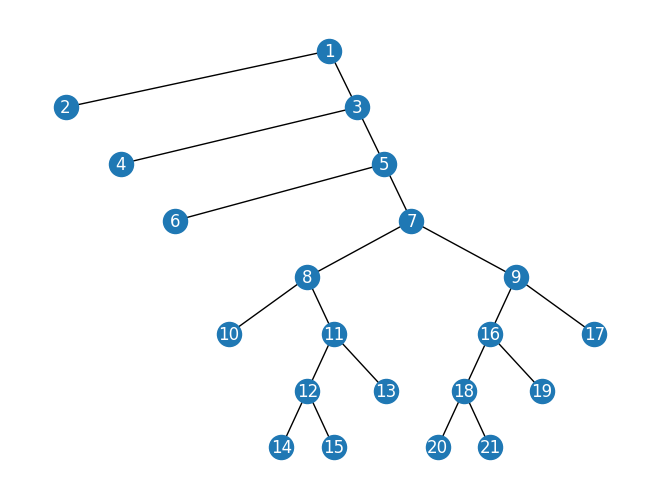

In [3]:
def postorder_count(node):
    """Recursively count nodes to compute the cardinality of a subtree for
    each node"""

    card = 0

    if node in left.keys():  # see if node has a left key
        postorder_count(left[node])
        card += card_subtree[left[node]]

    if node in right.keys(): # see if node has a right key
        postorder_count(right[node])
        card += card_subtree[right[node]]

    card_subtree[node] = 1 + card

def setpos(T, node, curpos, st_width, depth):

    """
    Set position depending on cardinality of each subtree
    """

    # Special condition: we are at the root
    if node == 1:
        T.add_node(node, pos=(0.5, 1))

    # Use a convex combination of subtree comparison and depth to assign a width to each subtree
    alpha = 0.01

    if node in left.keys():

        # X position in the graph should not just depend on depth,
        # otherwise we'd see a long and thin subtree and it would just
        # look like a path

        leftwidth = st_width * (alpha * .7 + (1 - alpha) *
                                card_subtree[left[node]] /
                                card_subtree[node])
        leftpos = curpos - (st_width - leftwidth) / 2

        T.add_node(left[node], pos=(leftpos, - depth))
        T.add_edge(node, left[node])
        setpos(T, left[node], leftpos, leftwidth, depth + 1)

    if node in right.keys():

        rightwidth = st_width * (alpha * .5 + (1 - alpha) *
                                 card_subtree[right[node]] /
                                 card_subtree[node])
        rightpos = curpos + (st_width - rightwidth) / 2

        T.add_node(right[node], pos=(rightpos, - depth))
        T.add_edge(node, right[node])
        setpos(T, right[node], rightpos, rightwidth, depth + 1)


postorder_count(1)  # assign card_subtree to each node

# Determine the position of each node depending on subtree cardinalities
setpos(T, 1, 0.5, 1, 0)

pos = nx.get_node_attributes(T, 'pos')

nx.draw(T, pos, labels=nodes, font_color='white')  # create B&B tree representation
plt.show()       # display the tree